# Simple sequence imitation with DQN in pytorch

In [1]:
import wandb

import os
import sys
sys.path.append('../environments')
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym
from gymnasium.spaces import Dict


import os
import sys
sys.path.append('../src/')
from neural_nets import DQN, exponential_schedule, linear_schedule
from buffer import ReplayBuffer
from scipy.spatial.distance import cdist

# import wandb

import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
def get_distance_matrix(X,Y):
  """"""
  return cdist(X,Y,metric='euclidean')

def get_distance(point1,point2):
    """Compute Euclidean distance between two points."""
    return np.linalg.norm(point1 - point2)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = False

In [3]:
env_name = 'ToyEnv_v1'
OUTDIR = f'results/{env_name}/'
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)
    
SEED = 10
seed_everything(SEED)

torch.set_default_dtype(torch.float32)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Simulate data

In [4]:
def get_target_fields(coords, distance_matrix):
    """
    Given a list of coordinates, picks the field closest to the origin first, then 
    always picks the field closest unless it has already been visited
    """
    ordered_indices = np.argsort(distance_matrix, axis=1) # low to high

    start_ind = np.argmin(np.sum(coords**2, axis=1))
    target_indices = [start_ind]

    last_ind = start_ind
    for i in range(len(coords) - 1):
        j = 0
        current_ind = ordered_indices[last_ind][j]
        while current_ind in target_indices:
            j += 1
            current_ind = ordered_indices[last_ind][j]
        target_indices.append(current_ind)
        last_ind = current_ind
    return target_indices, coords[target_indices]

In [ ]:
def get_simple_dataset(n_datasets=100):
    def get_target_fields(coords, distance_matrix):
        """
        Given a list of coordinates, picks the field closest to the origin first, then 
        always picks the field closest unless it has already been visited
        """
        ordered_indices = np.argsort(distance_matrix, axis=1) # low to high

        start_ind = np.argmin(np.sum(coords**2, axis=1))
        target_indices = [start_ind]

        last_ind = start_ind
        for i in range(len(coords) - 1):
            j = 0
            current_ind = ordered_indices[last_ind][j]
            while current_ind in target_indices:
                j += 1
                current_ind = ordered_indices[last_ind][j]
            target_indices.append(current_ind)
            last_ind = current_ind
        return target_indices, coords[target_indices]
    grid_max = 10
    ra_range = (-grid_max, grid_max)
    dec_range = (-grid_max, grid_max)
    n_points = grid_max
    
    # generate random coords
    ra_list = np.random.randint(ra_range[0], ra_range[1], size=(n_datasets, n_points))
    dec_list = np.random.randint(dec_range[0], dec_range[1], size=(n_datasets, n_points))
    coords = np.stack([ra_list, dec_list], axis=2) # shape (num_ep, nra_points, ndec_points)
    coords_dict = {f'eps{i}': coord for i, coord in enumerate(coords)}
    
    distance_matrices = np.empty(shape=(n_datasets, grid_max, grid_max))
    full_target_fields = []
    full_target_coords = []
    # get distance matrices
    for i in range(n_datasets):
        distance_matrices[i] = get_distance_matrix(coords[i], coords[i])
        np.fill_diagonal(distance_matrices[i], np.inf)
        target_fields, target_coords = get_target_fields(coords[i], distance_matrices[i])
        full_target_fields.append(target_fields)
        full_target_coords.append(target_coords)
        # full_target_coords.append(coords[i][target_fields])
    return np.array(full_target_fields), np.array(full_target_coords), coords_dict, coords

    

In [6]:
target_fields, target_coords, coords_dict, coords = generate_dataset(1)


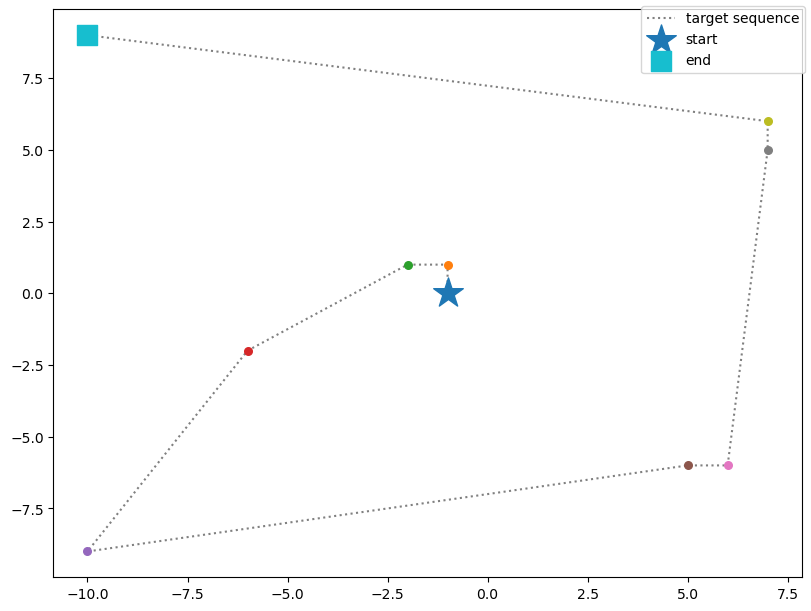

In [7]:
j = 0

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
ax.plot(target_coords[j][:, 0], target_coords[j][:, 1], linestyle='dotted', label='target sequence', zorder=1, color='grey')

for i, index in enumerate(target_fields[j]):
    if i == 0:
        marker = '*'
        s = 500
        label='start'
    elif i == len(target_fields[j])-1:
        marker = 's'
        s = 200
        label='end'
    else:
        marker = 'o'
        s = 30
        label=None
    ax.scatter(coords[j][index][0], coords[j][index][1], marker=marker, s=s, label=label)
# fig.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
fig.legend()

In [8]:
target_fields = target_fields[0]
target_coords = target_coords[0]
coords = coords[0]
coords_dict = {i: coord for i, coord in enumerate(coords_dict['eps0'])}

In [9]:
target_coords == coords[target_fields]

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [ ]:
class ToyEnv_v1(gym.Env):
    def __init__(self, coords_dict, max_visits, target_fields):
        super().__init__()
        # instantiate static attributes
        self.coords_dict = coords_dict # field_id: (x,y)
        self.nfields = len(coords_dict)
        self.max_visits = max_visits
        self.zenith = np.array([0.0,0.0])
        self.target_fields = target_fields
        self.total_visits = int(self.nfields * self.max_visits)

        # Initialize variable attributes - will be set in reset()
        self._init_to_nonstate()
       
        # Define observation space - (step, fieldid, nvisits array)
        self.obs_size = 2 + self.nfields
        self.observation_space = gym.spaces.Box(
            low=-1,
            high=1e5,
            shape=(self.obs_size,),
            dtype=np.float32,
        )

        # Define action space        
        self.action_space = gym.spaces.Discrete(self.nfields)

    
    
    # ------------------------------------------------------------ #
    # -----------------------Gymnasium API ----------------------- #
    # ------------------------------------------------------------ #

    def reset(self, seed=None, options=None):
        """Start a new episode.

        Args:
            seed: Random seed for reproducible episodes
            options: Additional configuration (unused in this example)

        Returns:
            tuple: (observation, info) for the initial state
        """
        # IMPORTANT: Must call this first to seed the random number generator
        super().reset(seed=seed)

        # initialize into a non-state.
        # this allows first field choice to be learned
        self._init_to_nonstate()
        obs = self._get_obs()
        info = self._get_info()
        return obs, info
    
    def step(self, action: int):
        """Execute one timestep within the environment.

        Args:

        Returns:
        """
        assert self.action_space.contains(action), f"Invalid action {action}"
        self._update_obs(action)
        # if self._step_count == 0:
        #     last_field_coord = self.zenith
        # else:
        #     last_field_coord = self.coords_dict[self._visited[-2]]

        # separation = get_distance(self._coord, last_field_coord)
        # if separation <= self.nfields//5*2:
        #     reward = 1
        # elif separation <= self.nfields//5*3:
        #     reward = .5
        # elif separation <= self.nfields//5*4:
        #     reward = .1
        # else:
        #     reward = 0

        if self._step_count < len(self.target_fields):
            correct_field = self.target_fields[self._step_count]
            if action == correct_field:
                reward = 1.0
            elif abs(action - correct_field) == 1:
                reward = .25
            else:
                reward = 0
        else:
            reward = 0

        # end condition
        truncated = False
        terminated = self._step_count + 1 >= self.total_visits

        # get obs and info
        obs = self._get_obs()
        info = self._get_info()
            
        return obs, reward, terminated, truncated, info

    # ------------------------------------------------------------ #
    # -------------Convenience functions-------------------------- #
    # ------------------------------------------------------------ #

    def _init_to_nonstate(self):
        self._step_count = -1
        self._field_id = -1
        self._nvisits = np.zeros(self.nfields, dtype=np.int32)
        self._visited = []
        self._coord = np.array([None, None])
        self._action_mask = np.ones(self.nfields, dtype=bool)

    def _update_action_mask(self):
        """Update mask for cutting invalid actions.
        Must update self._field and self._nvisits before updating actions
        """
        self._action_mask = self._nvisits < self.max_visits

    def _update_obs(self, action):
        self._step_count += 1
        self._field_id = action
        self._nvisits[action] += 1
        self._visited.append(action)
        self._coord = np.array(self.coords_dict[action], dtype=np.float32) #TODO need to change for closest distance learning

    def _get_obs(self):
        """Convert internal state to observation format.
    
        Returns:
            dict: Observation with agent and target positions
        """
        obs = np.concatenate((
            np.array([self._step_count], dtype=np.float32),
            np.array([self._field_id], dtype=np.float32),
            self._nvisits.astype(np.float32)
        ))
        return obs.astype(np.float32)

    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            
        """
        return {'action_mask': self._action_mask.copy()}

In [11]:
coords_dict, target_fields

({0: array([-1,  0]),
  1: array([-6, -2]),
  2: array([ 5, -6]),
  3: array([-10,   9]),
  4: array([7, 6]),
  5: array([ 6, -6]),
  6: array([7, 5]),
  7: array([-2,  1]),
  8: array([-1,  1]),
  9: array([-10,  -9])},
 array([0, 8, 7, 1, 9, 2, 5, 6, 4, 3]))

# Set up environment

In [12]:
# Register the environment so we can create it with gym.make()
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=ToyEnv_v1,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)
env = gym.make(f"gymnasium_env/{env_name}", coords_dict=coords_dict, max_visits=1, target_fields=target_fields)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)

from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


## Pytorch Agent and DQN implementation

In [ ]:
from typing import Tuple

class DQNAgent:
    def __init__(
            self,
            env: gym.Env, 
            replay_buffer: ReplayBuffer, 
            device,
            ):
        """Base Agent class handling the interaction with the environment.
        """
        self.env = env
        self.replay_buffer = replay_buffer
        self.device = device

        # get obs and action dims for network construction
        obs, _ = self.env.reset()
        n_observations = len(obs)
        n_actions = self.env.action_space.n

        # initialize networks
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.reset()
        self.steps_done = 0

    def reset(self) -> None:
        """Resets the environment and updates the state."""
        self.obs, self.info = self.env.reset()

    def select_action(self, epsilon: float) -> int:
        """
        Epsilon-greedy action selection
        """
        # if random sample less than epsilon, take random action
        if np.random.random() < epsilon:
            valid_actions = np.where(self.info['action_mask'])[0]
            action = np.random.choice(valid_actions)
            return int(action)

        # greedy selection from policy
        obs = torch.tensor(self.obs, dtype=torch.float32, device=self.device).unsqueeze(0)

        with torch.no_grad():
            q_values = self.policy_net(obs).squeeze(0)

            # mask invalid actions
            mask = torch.tensor(self.info['action_mask'], device=self.device, dtype=torch.bool)
            q_values[~mask] = float('-inf')
            action = torch.argmax(q_values).item()
        return int(action)

    @torch.no_grad()
    def play_step(
        self,
        epsilon: float = 0.0,
        buffer=None,
    ) -> Tuple[float, bool]:
        """
        Carries out a single interaction step between the agent and the environment and records experience
        """
        # select action
        action = self.select_action(epsilon)

        # interact with environment
        next_obs, reward, terminated, truncated, info = self.env.step(action)

        exp_args = (
            self.obs,
            action,
            reward,
            next_obs,
            terminated,
            self.info["action_mask"],
            info["action_mask"],
        )
        
        # if predicting
        if buffer is None:
            self.replay_buffer.append(*exp_args)
        else: # training
            buffer.append(*exp_args)

        # reset or move to next obs
        if terminated or truncated:
            self.reset()
        else:
            # set next_obs to current obs for next step
            self.obs = next_obs
            self.info = info

        return reward, terminated

    
    def predict(self, max_timesteps):
        """
        Rolls out policy.

        Returns
        ------
        buffer: ReplayBuffer
            Memory of this roll-out
        log: Dict
            Contains quantities that might be useful for diagnostics
        """
        log = {
            'rewards': [],
            'obs': [],
            # 'action': [],
            'terminated': [],
            'action_mask': []
            }
        
        self.reset()
        buffer = ReplayBuffer(max_timesteps, device=self.device)
        for _ in range(max_timesteps):
            reward, terminated = self.play_step(epsilon=0, buffer=buffer)

            log['rewards'].append(reward)
            log['terminated'].append(terminated)
            log['obs'].append(self.obs)
            log['action_mask'].append(self.info['action_mask'])

            if terminated:
                break
        return buffer, log
                

## How does model do with no training?

In [15]:
agent = DQNAgent(
    env=env,
    replay_buffer=ReplayBuffer(10000, device=device),
    device=device
)

In [16]:
buffer, log = agent.predict(50)

In [17]:
buffer.buffer

deque([Experience(obs=array([-1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
             dtype=float32), action=8, reward=0, next_obs=array([0., 8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32), done=False, action_mask=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
               True]), next_action_mask=array([ True,  True,  True,  True,  True,  True,  True,  True, False,
               True])),
       Experience(obs=array([0., 8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32), action=9, reward=0.25, next_obs=array([1., 9., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], dtype=float32), done=False, action_mask=array([ True,  True,  True,  True,  True,  True,  True,  True, False,
               True]), next_action_mask=array([ True,  True,  True,  True,  True,  True,  True,  True, False,
              False])),
       Experience(obs=array([1., 9., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], dtype=float32), action=7, reward=1.0, next_obs=a

In [18]:
print([exp[1] for exp in buffer.buffer])
print(target_fields)

[8, 9, 7, 1, 3, 4, 6, 5, 0, 2]
[0 8 7 1 9 2 5 6 4 3]


# Train

In [ ]:
from collections.abc import Callable

def train_agent(
        agent: DQNAgent,
        total_timesteps: int,
        lr: float,
        batch_size: int,
        gamma: float,
        eps_scheduler_kwargs: dict[str, int | str],
        tau: float,
        eps_scheduler: Callable,
        learn_start: int,
        train_freq: int, #4
        target_freq: int,
        optimizer_kwargs: Dict = {},
        lr_scheduler_kwargs: Dict = {},
        wandb_run=None
        ):
    """
    Trains a DQN agent.
    
    Args
    -----
    agent: DQNAgent
    total_timesteps: int
        Total number of timesteps through which to step agent through environment.
        Number of episodes is total_timesteps // episode_steps
    lr: float
    batch_size: int
    gamma: float
    eps_scheduler_kwargs: dict[str, int | str]
        arguments for epsilon scheduling method
    tau: float
    eps_scheduler: Callable,
        Function that calculates epsilon at each time step
    optimizer: torch.optim.Optimizer,
        Optimizer for neural network. Adamw is recommended.
    optimizer_kwargs: Dict,
        Kwargs for chosen optimizer
    learn_start: int
        Time step at which updates to policy network and target network 
    train_freq: int, #4
        Number of time steps between policy network updates  
    target_freq: int
        Number of time steps between target network updates

    Returns
    -------
    None
    """
    agent.reset()

    optimizer = torch.optim.AdamW(agent.policy_net.parameters(), lr=lr, amsgrad=False, **optimizer_kwargs)

    T_max = (total_timesteps - learn_start) // train_freq
    lr_scheduler_kwargs = {'T_max': total_timesteps - learn_start, 'eta_min': 1e-6}
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, **lr_scheduler_kwargs)
    device = agent.device
    loss_history = []

    for t_i in range(total_timesteps):
        # set epsilon according to scheduler
        epsilon = eps_scheduler(t=t_i, **eps_scheduler_kwargs)
        if wandb_run:
            wandb_run.log({'epsilon': epsilon}, step=t_i)

        # agent performs step in environment and sees next observation
        reward, terminated = agent.play_step(epsilon)
        
        # train - use temporal difference between new obs and last obs to update Q-values
        if t_i > learn_start and batch_size <= len(agent.replay_buffer) and (t_i % train_freq == 0):
            # sample from experiences
            obs, actions, rewards, next_obs, dones, _, next_action_masks = agent.replay_buffer.sample(batch_size)
            
            # convert to tensors
            obs = torch.tensor(np.array(obs), device=device, dtype=torch.float32)
            actions = torch.tensor(actions, device=device, dtype=torch.long).unsqueeze(1)
            rewards = torch.tensor(rewards, device=device, dtype=torch.float32)
            dones = torch.tensor(dones, device=device, dtype=torch.float32)
            next_obs = torch.tensor(np.array(next_obs), device=device, dtype=torch.float32)

            # wandb_run.log({'batch_rewards': rewards}, step=t_i)
            # get current q vals
            q_vals = agent.policy_net(obs)
            current_q = q_vals.gather(1, actions).squeeze()


            with torch.no_grad():
            # gets maximally valued action for each observation in batch
                next_q = agent.target_net(next_obs)

                # mask invalid actions
                mask_tensor = torch.tensor(next_action_masks, device=device, dtype=torch.bool)
                next_q[~mask_tensor] = -1e9# float('-inf')
                # wandb_run.log({'masked next q': next_q},step=t_i)

                max_next_q = next_q.max(dim=1)[0]
                # print('(7) max_masked_next_q', max_next_q)

                td_target = rewards + gamma * max_next_q * (1 - dones) # , dtype=torch.float32, device=device

            
            # print('td_target', td_target)
            loss = F.mse_loss(current_q, td_target)
            if wandb_run:
                wandb_run.log({'loss': loss.item()}, step=t_i)
            loss_history.append(loss.item())

            # optimize w/ backprop
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.policy_net.parameters(), max_norm=1.)
            optimizer.step()
            scheduler.step()

            # update target network
            if t_i % target_freq == 0:
                for target_param, param in zip(agent.target_net.parameters(), agent.policy_net.parameters()):
                    target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
    if not wandb_run:
        env.close()
    return loss_history

In [85]:
config = {
    'batch_size': 32,
    'gamma': .99,
    'eps_scheduler_kwargs': {'eps_start': .9, 'eps_end': .01, 'decay_rate': 2500},
    'tau': .005,
    'lr': 1e-2,
    'total_timesteps': 10000,
    'learn_start': 100,
    'train_freq': 4,
    'target_freq': 100
}

agent = DQNAgent(
    env=env,
    replay_buffer=ReplayBuffer(capacity=100000, device=device),
    device=device
)

In [86]:
loss_history = train_agent(
    agent=agent,
    eps_scheduler=exponential_schedule,
    **config
)

In [87]:
loss_history

[0.30187755823135376,
 0.5405961275100708,
 0.4162525534629822,
 0.28009411692619324,
 0.13261401653289795,
 0.27716484665870667,
 0.2601093053817749,
 0.17107170820236206,
 0.18371494114398956,
 0.1810331493616104,
 0.1217440813779831,
 0.0805160254240036,
 0.06756344437599182,
 0.20459827780723572,
 0.08619482815265656,
 0.07847300171852112,
 0.08964040875434875,
 0.044586461037397385,
 0.08055797219276428,
 0.035620421171188354,
 0.1260533481836319,
 0.13375689089298248,
 0.13009092211723328,
 0.0899268165230751,
 0.07609313726425171,
 0.039733096957206726,
 0.07817263901233673,
 0.06633526086807251,
 0.06700249016284943,
 0.06594578921794891,
 0.04735581576824188,
 0.01765439286828041,
 0.07133979350328445,
 0.03443260118365288,
 0.09252183139324188,
 0.09758652746677399,
 0.041248954832553864,
 0.04351180046796799,
 0.06375180184841156,
 0.030360259115695953,
 0.06580433994531631,
 0.02792447805404663,
 0.09657815843820572,
 0.05624058470129967,
 0.03310992196202278,
 0.0417347475

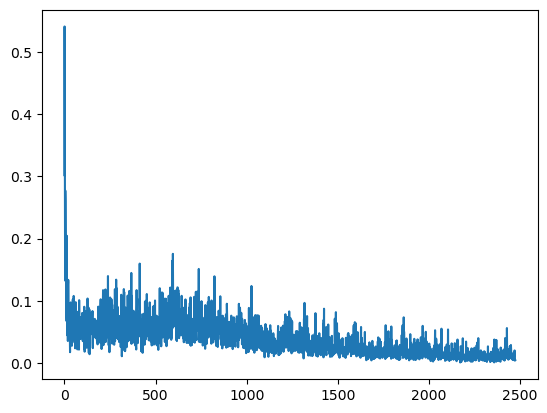

In [88]:
plt.plot(loss_history)

In [89]:
entity = 'rhur-uc'
project = 'simple-sequence-imitation'
run_id = 102

In [91]:
with wandb.init(project=project, id=str(run_id), config=config) as run:
    found_id = True
    loss_hist_wandb = train_agent(
        agent=agent,
        eps_scheduler=exponential_schedule,
        wandb_run=run,
        **config
    )

epsilon,██▇▇▇▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▇▃▃▃▄▅▅█▂▅▂▄▃▂▃▂▅▃▆▃▂▃▃▃▅▂▄▇▃▄▃▄▃▁▂▂▂▂
epsilon,0.02631
loss,0.01041


In [92]:
api = wandb.Api()
run = api.run(f"{entity}/{project}/{run_id}")

In [93]:
run_hist = run.history()

In [94]:
run_hist.keys()

Index(['_step', '_runtime', 'epsilon', '_timestamp', 'loss'], dtype='object')

In [97]:
len(loss_hist_wandb)

2474

In [100]:
len(run_hist['loss'])

500

In [46]:
mask = ~np.isnan(run_hist['loss'].values)

# Results

In [53]:
agent.replay_buffer.buffer

deque([Experience(obs=array([-1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
             dtype=float32), action=7, reward=0, next_obs=array([0., 7., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32), done=False, action_mask=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
               True]), next_action_mask=array([ True,  True,  True,  True,  True,  True,  True, False,  True,
               True])),
       Experience(obs=array([0., 7., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32), action=0, reward=0, next_obs=array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32), done=False, action_mask=array([ True,  True,  True,  True,  True,  True,  True, False,  True,
               True]), next_action_mask=array([False,  True,  True,  True,  True,  True,  True, False,  True,
               True])),
       Experience(obs=array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32), action=5, reward=0, next_obs=array(

In [156]:
buffer, log = agent.predict(200)

In [157]:
[exp[1] for exp in buffer.buffer]

[0, 8, 7, 1, 9, 2, 5, 6, 4, 3]

In [158]:
target_fields

array([0, 8, 7, 1, 9, 2, 5, 6, 4, 3])